# Final Project  - Gapfilling Satellite Soil Moisture Time Series using Machine Learning

In [14]:
import os
import utils as utils
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # force CPU
import torch
import torch.nn as nn
torch.manual_seed(123)
device = torch.device("cpu")
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import cartopy.crs as ccrs
from scipy.stats import theilslopes
import ipywidgets as widgets
from statsmodels.tsa.stattools import adfuller
from pytesmo.time_series.anomaly import calc_anomaly, calc_climatology
from pytesmo.interpolate.dctpls import smoothn
import pickle

# Data Selection
The following cell will load the data sample for the rest of the notebook from the available test locations. The time series data will be stored in the global variable `DATA` and the longitude and latitude of the test location as `LON` and `LAT`, respectively.

**Data will be used as selected here when running other cells of this notebook**

In [15]:
@widgets.interact(
    location=widgets.Dropdown(
        options=['Romania', 'Spain1', 'Spain2', 'Austria', 'Germany1', 'Germany2', 'Italy', 'Netherlands'],
        description='Select location:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px')),
    period=widgets.IntRangeSlider(
        value=[2015, 2020], min=2015, max=2020, step=1, description="Period [year]", 
        layout=widgets.Layout(width='400px'), continuous_update=False)
)
def load_data(location, period):
    global DATA, LAT, LON, LOCATION
    LOCATION = location
    sat, rean, insitu, LAT, LON = utils._load_data(location)
    print(f"\nLoading data for study site: {location} (Lat={LAT}°, Lon={LON}°)")
    print(f"Period: {period[0]}-01-01 to {period[1]}-12-31\n")

    fig = plt.figure(figsize=(12, 5))
    ax_map = plt.axes([0.0, 0.15, 0.4, 0.4], projection=ccrs.PlateCarree())
    utils._marker_on_map(LAT, LON, ax_map)
    DATA = pd.concat([rean, sat, insitu], axis=1)
    DATA.index.name = "Date"
    DATA = DATA.loc[f"{period[0]}-01-01":f"{period[1]}-12-31", :]
    # todo: add R scores
    ax = plt.axes([0.45, 0.15, 0.5, 0.4])
    ylabel = 'Vol. SM [m³/m³]'
    ax.set_title(f'Soil moisture at \'{LOCATION}\' site (daily mean)', fontsize = 15)
    DATA[['satellite SM']].plot(ylabel=ylabel, color='red', label='Satellite', ax=ax)
    DATA[['reanalysis SM']].plot(ylabel=ylabel, color='blue', label='ERA5-Land', ax=ax)
    DATA[['in situ SM']].plot(ylabel=ylabel, color='green', label='In situ', ax=ax)
    plt.show()

plt.show()

interactive(children=(Dropdown(description='Select location:', layout=Layout(width='300px'), options=('Romania…

# Explorative Data Analysis

## Signal decomposition

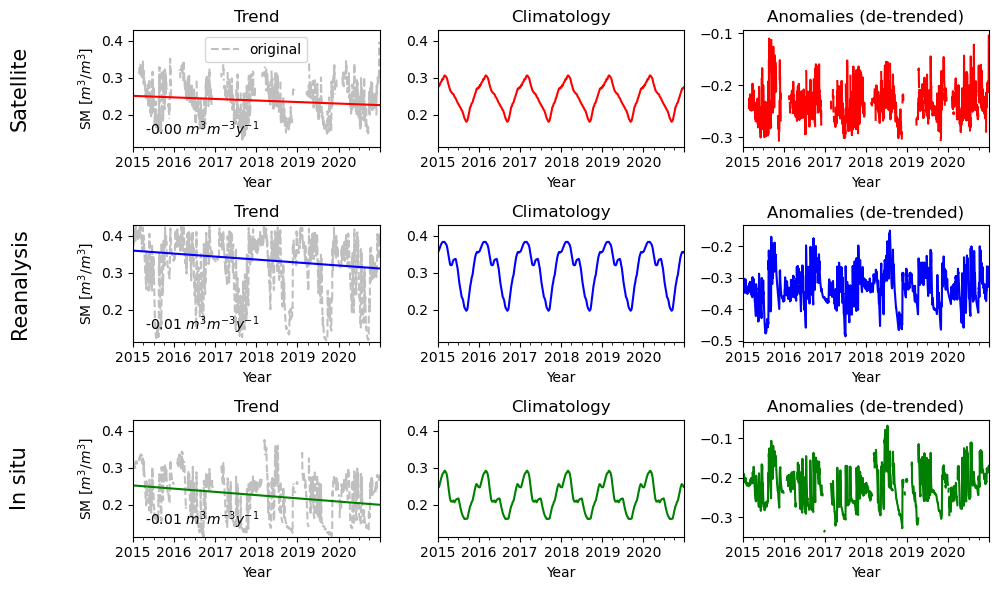

In [16]:
def calc_trend(ts) -> (pd.Series, float, float):
    x, y = ts.index.to_julian_date().values, ts.values
    slope, intercept, _, _ = theilslopes(y, x)  # slope unit = julian date (day)
    trend = pd.Series(index=ts.index, data=slope * x + intercept)
    return trend, slope, intercept


cols = ['satellite SM', 'reanalysis SM', 'in situ SM']
colors = ["red", "blue", "green"]
vrange = (DATA[cols].min().min(), DATA[cols].max().max())

fig, axs = plt.subplots(3, 3, figsize=(10, 6))
row = 0
for col in cols:
    # plot absolute values
    DATA[col].plot(linestyle='--', color='gray', alpha=0.5, ax=axs[row, 0], label='original', 
                   legend=True if row == 0 else False)
    # plot trend
    trend, slope, _ = calc_trend(DATA[col].dropna().copy())
    trend.plot(ax=axs[row, 0], style='-', color=colors[row], xlabel="Year", title='Trend', ylabel="SM [$m^3/m^3$]", ylim=vrange)
    # plot climatology and detrended anomalies
    clim = calc_climatology(DATA[col].copy())
    dat = calc_anomaly(DATA[col].copy(), climatology=clim, return_clim=True)
    axs[row, 0].text(x=0.05, y=0.1, s=f"{slope*365:.2f} "+"$m^3 m^{-3} y^{-1}$", transform=axs[row, 0].transAxes)
    dat['climatology'].plot(ax=axs[row, 1], style='-', color=colors[row], xlabel="Year",
                           title='Climatology', ylim=vrange)
    (dat['anomaly'] - trend).plot(ax=axs[row, 2], style='-', color=colors[row], xlabel="Year",
                       title='Anomalies (de-trended)')
    axs[row, 0].text(s=col.replace(' SM', '').capitalize(), x=-0.5, y=0.5, transform=axs[row, 0].transAxes, 
                     rotation=90, verticalalignment='center', fontsize=15)
    DATA[f"{col} Anomaly"] = dat['anomaly']
    DATA[f"{col} Climatology"] = dat["climatology"]
    DATA[f"{col} Trend"] = trend
    row += 1

plt.tight_layout()

## Plotting data distributions

Some differences are due to missing data points in the satellite and in situ time series

In [17]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Absolute Values', 'Anomalies'],
        description='Select Data to use:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)
def compute_dist(comp):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    
    colors = ['red', 'blue', 'green']
    cols = [f'{c} Anomaly' if comp == 'Anomalies' else c for c in ['satellite SM', 'reanalysis SM', 'in situ SM']]
    for i, col in enumerate(cols):
        dat = DATA[col]
        sns.histplot(dat, color=colors[i], kde=True, bins=10, cumulative=False, stat="probability", ax=axs[i])
        axs[i].set_title(col.replace(' SM', '').capitalize())
        text = (f"med={dat.median():.2f}\n" f"std={dat.std():.2f}\n"
                f"min={dat.min():.2f}\n" f"max={dat.max():.2f}")
    
        axs[i].legend([utils._l], [text], loc="best", frameon=True, handlelength=0, handletextpad=0, fontsize=9)
    
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='Select Data to use:', layout=Layout(width='300px'), options=('Abso…

## Testing for stationarity

A p-value below 0.05 indicates that the time series is stationary

In [18]:
# TODO: indicate what stats mean


# Testing for stationarity via Augumented-Dickey Fuller Test
prods = ['satellite SM', 'reanalysis SM', 'in situ SM']
stats = pd.DataFrame(index=['Test statistic', 'p-value'],
                     columns=pd.MultiIndex.from_product([prods, ['Absolute', 'Anomaly']]),
                     data=np.nan)

for i, col in enumerate(stats.columns.values):
    name = ' '.join(col).replace(' Absolute', '')
    res = adfuller(DATA[name].dropna())
    stats.loc['Test statistic', col] = round(res[0], 3)
    # Only if the p-value were to be close to significant, the critical values should be used to judge the hypothesis rejection
    stats.loc['p-value', col] = round(res[1], 5)
    if i == 0:
        for key, value in res[4].items():
            print(f"{key} critical value: {round(value, 3)}")

stats

1% critical value: -3.435
5% critical value: -2.863
10% critical value: -2.568


satellite SM         reanalysis SM         in situ SM        
                   Absolute Anomaly      Absolute Anomaly   Absolute Anomaly
Test statistic     -3.98200 -13.086      -4.43900   -6.83     -6.564  -9.128
p-value             0.00151   0.000       0.00025    0.00      0.000   0.000

## Correlation Analysis

In [19]:
@widgets.interact(
    comp=widgets.Dropdown(
        options=['Absolute SM Values', 'SM Anomalies'],
        description='Select Data to use:', style={'description_width': '120px'}, layout=widgets.Layout(width='300px'))
)
def compute_xcorr(comp):
    global CORR
    col, pearson_sat, pearson_rean = np.array([]), np.array([]), np.array([])
    pfix = ' Anomaly' if comp == 'SM Anomalies' else ''
    for param in DATA.columns:
        if ' SM' in param:
            continue
        dat = DATA[[f"reanalysis SM{pfix}", param]].dropna()  # keep only common obs
        r_rean = scipy.stats.pearsonr(dat[f'reanalysis SM{pfix}'].values, dat[param].values)[0]
        dat = DATA[[f'satellite SM{pfix}', param]].dropna()  # keep only common obs
        r_sat = scipy.stats.pearsonr(dat[f'satellite SM{pfix}'].values, dat[param].values)[0]
        col = np.append(col, param)
        pearson_sat = np.append(pearson_sat, float(r_sat))
        pearson_rean = np.append(pearson_rean, float(r_rean))
    
    order = np.argsort(pearson_rean)
    CORR = pd.DataFrame(index=col[order], data={'Satellite': pearson_sat[order], 'Reanalysis': pearson_rean[order]})
    
    ax = CORR.plot.barh(xlabel='Correlation [-]', color=["red", "blue"])
    ax.set_title("Soil Moisture Correlation with Reanalysis variables")

interactive(children=(Dropdown(description='Select Data to use:', layout=Layout(width='300px'), options=('Abso…

## Lag analysis
Exploring temporal cross-correlations between the reanalysis soil moisture and other variables. Short-term (event-based, a few days) and long-term (seasonal, multiple months) patterns are expected.

In the short term (a few days):
- For events causing changes in soil moisture, POSITIVE lags are expected (e.g. rainfall)
- For events caused by changes in soil moisture, NEGATIVE lags are expected (e.g. evaporation, vegetation decline)


In [20]:
def cross_corr(df, lag=0):
    """Correlation between 2 columns, where one is delayed by n days (lag)"""
    col1, col2 = df.columns
    if col1 == col2:  # Autocorrelation case
        return df.iloc[:, 0].autocorr(lag=lag)
    else:
        return df[col1].corr(df[col2].shift(lag))

@widgets.interact(
    lag_range=widgets.IntRangeSlider(
        value=(-100, 100), min=-366, max=366, step=3, description="Lag [days]", 
        layout=widgets.Layout(width='400px'), continuous_update=False, style={'description_width': '120px'}))
def compute_xcrorr(lag_range):
    lags = np.arange(*lag_range)
    n_rows, n_cols = 5, 4
    params = ["reanalysis SM"] + list(CORR.index.values[::-1])
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    
    i = 0
    for r in range(n_rows):
        for c in range(n_cols):
            if i >= len(params):
                break
            p = params[i]
            xcorr = [cross_corr(DATA[["reanalysis SM", p]], lag=lag) for lag in lags]
            axs[r, c].plot(lags, xcorr, linewidth=1, color='orange' if p == "reanalysis SM" else "blue")
            axs[r, c].set_ylim(-1, 1), axs[r, c].set_xlim(*lag_range)
            axs[r, c].set_xlabel("Lag [days]")
            if c == 0:
               axs[r, c].set_ylabel("R [-]")
            axs[r, c].set_title(p[:35] if p != "reanalysis SM" else "Soil Moisture (Autocorrelation)", fontsize=10)
            i += 1
        
    plt.tight_layout()

interactive(children=(IntRangeSlider(value=(-100, 100), continuous_update=False, description='Lag [days]', lay…

## Gap Analysis

### Gap Distribution

Satellite Data Gap Stats:
  Mean gap length:  4.65
  Median gap length:  1.0
  Min gap size:  1
  Max gap size:  81
  N missing:  618
  % missing data points:  28


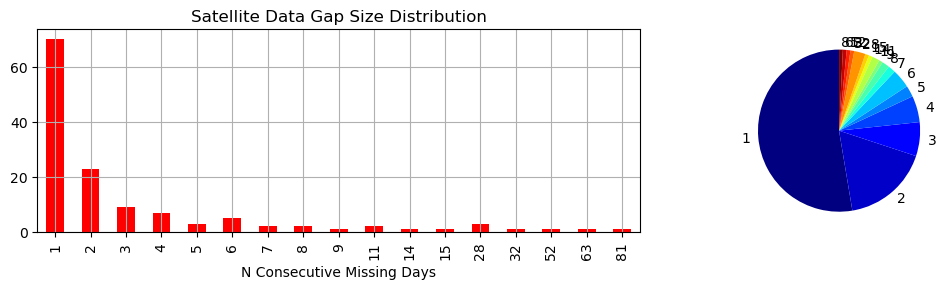

In [21]:
def count_gaps(arr, dates):
    arr = np.asarray(arr)
    # Find indices where value changes
    diff = np.diff(np.r_[0, arr, 0])

    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    startdates =  dates[starts]

    return pd.DataFrame(index=startdates, 
                        data={'gapsize': (ends - starts).tolist()})

gaps_df = count_gaps(np.isnan(DATA['satellite SM'].values), DATA['satellite SM'].index.values)

uniq = np.unique_counts(gaps_df['gapsize'])
gap_counts = pd.Series(uniq.counts, uniq.values)

print("Satellite Data Gap Stats:")
print('  Mean gap length: ', round(np.mean(gaps_df.values), 2))
print('  Median gap length: ', np.median(gaps_df.values))
print('  Min gap size: ', np.min(gaps_df.values))
print('  Max gap size: ', np.max(gaps_df.values))
print('  N missing: ', np.sum(gaps_df.values))
print('  % missing data points: ', int(len(DATA[DATA['satellite SM'].isna()].index) / len(DATA.index)*100))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3), width_ratios=[0.5, 0.4])

gap_counts.plot.bar( ax=ax1, title="Satellite Data Gap Size Distribution", 
                  xlabel='N Consecutive Missing Days',
                  grid=True, color='red')
gap_counts.plot.pie(cmap=plt.get_cmap('jet'), ax=ax2, startangle=90)
fig.tight_layout()

###todo: check why hist wrong


Check when the largest gaps appear within a year

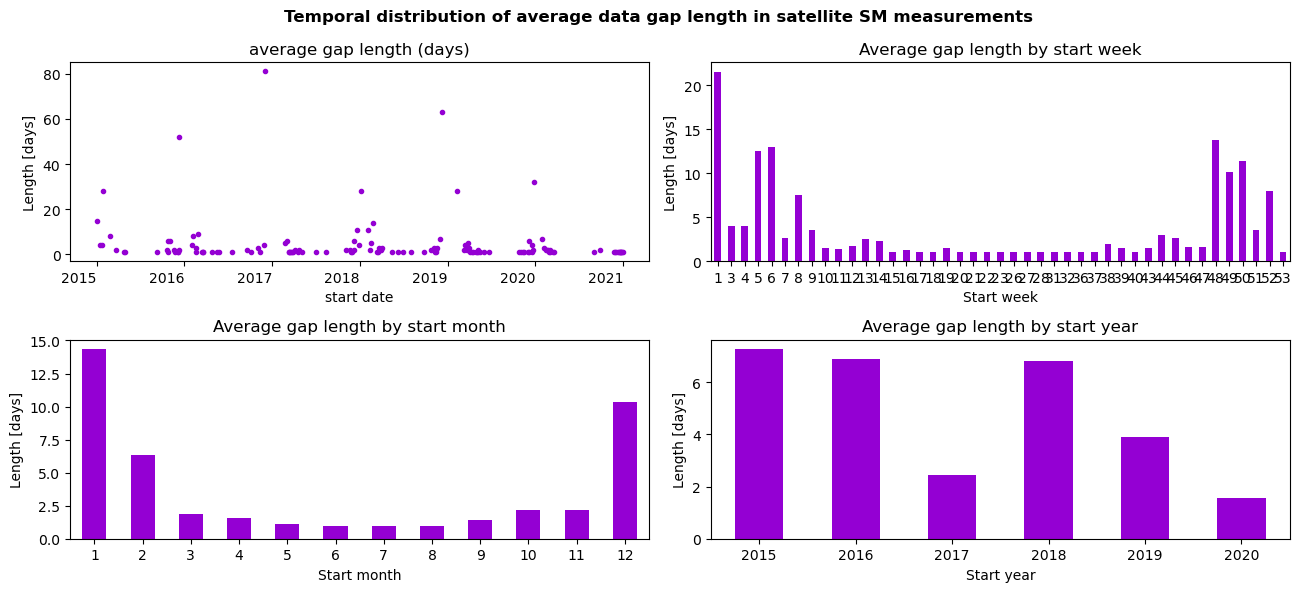

In [22]:
gaps_df['month'] = gaps_df.index.month
gaps_df['weekofyear'] = gaps_df.index.isocalendar().week
gaps_df['year'] = gaps_df.index.year

fig, axs = plt.subplots(2, 2, figsize = (13, 6))
data_gap_dates, data_gap_list = gaps_df.index.values, gaps_df.values
gaps_df['gapsize'].plot(color='darkviolet', title='average gap length (days)', rot=0,
                        marker='.', linewidth=0, ax=axs[0, 0], ylabel='Length [days]', xlabel='start date',
                       )
avg_gapsize_week = gaps_df.groupby('weekofyear').mean()['gapsize']
avg_gapsize_week.plot.bar(
    ax=axs[0, 1], ylabel='Length [days]', xlabel='Start week', color='darkviolet', 
    rot=0, title='Average gap length by start week')
avg_gapsize_month = gaps_df.groupby('month').mean()['gapsize']
avg_gapsize_month.plot.bar(
    ax=axs[1, 0], ylabel='Length [days]', xlabel='Start month', color='darkviolet', 
    rot=0, title='Average gap length by start month')
avg_gapsize_year = gaps_df.groupby('year').mean()['gapsize']
avg_gapsize_year.plot.bar(
    ax=axs[1, 1], ylabel='Length [days]', xlabel='Start year', color='darkviolet', 
    rot=0, title='Average gap length by start year')

fig.suptitle('Temporal distribution of average data gap length in satellite SM measurements', weight = 'bold')
plt.tight_layout()


In [23]:
def markov_gaps(reference: pd.Series) -> pd.Series:
    transitions = {}
    reference.name = 'sm'
    dat = pd.DataFrame(reference)
    dat['sm_available'] = (~np.isnan(dat['sm'])).astype(int)
    dat['month_of_year'] = dat.index.month
    for month, group in dat.groupby('month_of_year'):
        x = group['sm_available'].values
        P00 = ((x[:-1]==0) & (x[1:]==0)).sum() / (x[:-1]==0).sum()
        P01 = 1 - P00
        P11 = ((x[:-1]==1) & (x[1:]==1)).sum() / (x[:-1]==1).sum()
        P10 = 1 - P11
        transitions[month] = [[P00, P01],[P10,P11]]
    
    # ** Simulate gaps 
    states = []
    current_state = 0 # Initial state
    for month_of_day in dat["month_of_year"]:
        # Get current state from previous state by random sampling according to the transition matrix
        current_state = np.random.choice([0, 1], p=transitions[month_of_day][current_state])
        states.append(current_state)
        
    dat["gaps"] = states

    return ~dat['gaps'].astype(bool)


@widgets.interact(
    strategy=widgets.Dropdown(
        options=['Satellite-like (simulated)', 'Satellite gaps (original)', 
                 '30% random', '50% random', '10% forecast'],
        description='Select Gap Strategy:', style={'description_width': '140px'}, layout=widgets.Layout(width='300px')),
)
def train_test_split(strategy):
    global PREDICTION
    PREDICTION = pd.DataFrame(data={'original': DATA['reanalysis SM'].copy()})

    if strategy == 'Satellite gaps (original)':
        PREDICTION['gaps'] = np.isnan(DATA['satellite SM'])
    elif strategy == 'Satellite-like (simulated)':
        PREDICTION['gaps'] = markov_gaps(DATA['satellite SM'])
    elif strategy.endswith("random"):
        percent_random = int(strategy.split('%')[0])
        PREDICTION['gaps'] = False
        rand_idx = sorted(np.random.choice(list(range(len(PREDICTION.index))), 
                                           size=int(len(PREDICTION.index) * (percent_random / 100)), replace=False))
        PREDICTION.iloc[rand_idx, 1] = True
    elif strategy.endswith("forecast"):
        precent = int(strategy.split('%')[0])
        PREDICTION['gaps'] = False
        N = int(len(PREDICTION.index) * (precent / 100))
        PREDICTION.iloc[slice(-N, None), 1] = True
    else:
        raise NotImplementedError()

    #Select which gap type to use
    PREDICTION['test'] = PREDICTION.loc[PREDICTION['gaps'] == True, 'original']
    PREDICTION['train'] = PREDICTION.loc[PREDICTION['gaps'] == False, 'original']

    print(f"N train = {len(PREDICTION.train.dropna())}, N test = {len(PREDICTION.test.dropna())}")

    display(PREDICTION)

interactive(children=(Dropdown(description='Select Gap Strategy:', layout=Layout(width='300px'), options=('Sat…

# Baseline Predictions
1) Forward Filling
2) Linear Interpolation
3) DCT-PLS (cosine transform fit - 2d = without spatial neighbourhood information)

In [24]:
PREDICTION['filled_dctpls'] = smoothn(PREDICTION['train'].values.copy(), isrobust=True)[0]
PREDICTION['filled_const'] = PREDICTION['train'].ffill().bfill()
PREDICTION['filled_linear'] = PREDICTION['train'].interpolate('linear', limit_direction='both')

for col in PREDICTION.columns:  # Only keep new values
    if col.startswith('filled_'):
        PREDICTION.loc[~PREDICTION['gaps'], col] = np.nan

<Axes: title={'center': 'Baseline Predictions'}, xlabel='Date'>

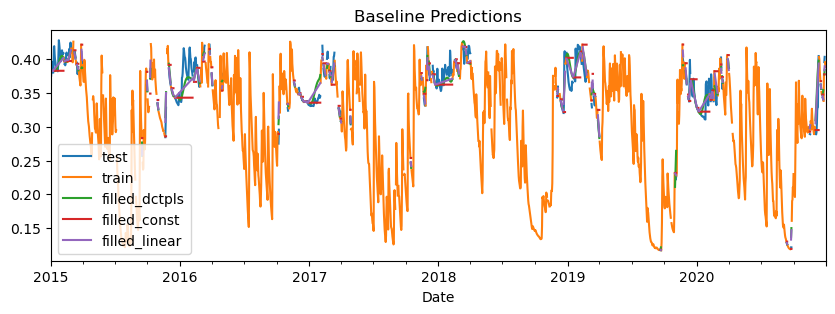

In [12]:
PREDICTION.drop(columns='original').plot(figsize=(10, 3), title='Baseline Predictions')

# LSTM Training

We use the ERA5-Land reanalysis data from up to 1000 locations across Europe for training (the sample size can be chosen freely, larger samples should lead to a better model). We don't use any data at the test locations for training! The model parameters after training will be stored for future use (as training can take quite long).

## LSTM Model Definition

In [27]:
class BiLSTMModel(nn.Module):
    """
    Bidirectional two-layer LSTM for Soil Moisture prediction.

    Architecture:
        Input  : (batch, window, n_features)
        Bi-LSTM Layer 1  : captures short-term feature interactions,
                           output is 2*hidden_size dimensional
        Dropout          : standard dropout between the two LSTM layers
        Bi-LSTM Layer 2  : captures long-term trends from layer-1 hidden states
        Time-Distributed Dense (fc): maps each time-step hidden state to a
                           scalar, applied identically across all time steps
        Output activation: y = 0.1 + 0.9 * sigmoid(out)
                           → constrains predictions to [0.1, 1.0] (soil moisture range)
    """
    def __init__(self, n_features: int, hidden_size: int = 64, dropout: float = 0.2):
        super().__init__()
        self.bilstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(p=dropout)
        self.bilstm2 = nn.LSTM(
            input_size=2 * hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(2 * hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.bilstm1(x)
        out     = self.dropout(out)
        out, _ = self.bilstm2(out)
        logits  = self.fc(out)
        #logits  = logits[:, -1, :]                   # last time step → (batch, 1)
        logits = logits.mean(dim=1)
        return 0.1 + 0.9 * torch.sigmoid(logits)


class TimeSeriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def make_windows(df, features, target, window, stride=10):
    X, y = [], []
    for i in range(window, len(df), stride):
        X.append(df[features].iloc[i - window:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)


reanalysis_reader = utils.ReanalysisReader("extra_era5land_europe/era5land_*.csv")


def encode_gaps(s: pd.Series, max_gap: int = 60) -> pd.Series:
    """ Fill gaps with consecutive counts that indicate the uncertainty"""
    is_nan = s.isna().astype(int)
    groups = (is_nan.diff() != 0).cumsum()
    return is_nan.groupby(groups).cumsum().clip(upper=max_gap)

    
def load_location(i_loc, add_markov_gaps_sm=True) -> TimeSeriesDataset:
    """Load, scale, and window a single location. Only this stays in RAM."""
    df = reanalysis_reader.read_fid(i_loc)

    # We add some gaps to the soil moisture data
    if add_markov_gaps_sm:
        gaps = markov_gaps(DATA.loc['2010-01-01':'2020-12-31', 'satellite SM'])
        df.loc[gaps[gaps].index, 'reanalysis SM'] = np.nan
        
    return df

def preprocess_columns(df, columns=None):
    df['doy_sin'] = np.sin(2*np.pi * df.index.dayofyear / 365.25)
    df['doy_cos'] = np.cos(2*np.pi *  df.index.dayofyear / 365.25)
    # apply log transform to precipitation data
    df['Total precipitation'] = np.log(1 + df['Total precipitation'].values)

    # add a separate mask variable
    df['mask'] = np.isnan(df['reanalysis SM'].values).astype(int)
    df['timedelta'] = encode_gaps(df['reanalysis SM'])

    if columns is not None:
        df = df[columns]

    return df


"""
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, predictions, targets):
        mse_loss = torch.mean((predictions - targets) ** 2)
        penalty = torch.mean(predictions ** 2)
        return mse_loss + 0.1 * penalty
"""

class MaskedMSELoss(nn.Module):
    """ TODO: This ignored the gap values and tunes based on the other data points"""
    def forward(self, preds, targets):
        mask = targets > 0
        return ((preds[mask] - targets[mask]) ** 2).mean()



def run_batches(model, loader, criterion, optimizer=None) -> float:
    """
    One pass over a DataLoader.
    optimizer given  →  training pass (gradients computed + applied)
    optimizer=None   →  validation pass (no gradients)
    Returns mean loss over all samples in the loader.
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_samples = 0.0, 0
    ctx = torch.enable_grad() if is_train else torch.no_grad()

    with ctx:
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if is_train:
                optimizer.zero_grad()
            preds = model(xb)
            loss  = criterion(preds, yb)
            if is_train:
                loss.backward()
                optimizer.step()
            total_loss    += loss.item() * xb.size(0)
            total_samples += xb.size(0)

    return total_loss / total_samples

In [28]:
TODO:
- add custom loss function
- Training locations should be taken around the current target location?

SyntaxError: invalid syntax (3032213067.py, line 1)

In [29]:
# Training params
train_locs = 5   # number of (shuffled) locations used for training (up to 1000)
test_locs = 2

window = 150   # Temporal window length (days) for each location
stride = 10  # Step size (days) between windows
batchsize = 32
hidden_size = 64
dropout = 0.2
learn_rate = 0.001
n_epochs = 1000

columns = ['reanalysis SM', 
           'Total precipitation', 'Skin temperature', 'Potential evaporation', 
           'mask', 'timedelta', 'doy_sin', 'doy_cos']

# Early stopping
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0
best_state = None

rng = np.random.default_rng(123)

all_loc_ids = list(range(len(reanalysis_reader.files)))
rng.shuffle(all_loc_ids)

train_loc_ids = all_loc_ids[:train_locs]
val_loc_ids = all_loc_ids[train_locs:train_locs+test_locs]

print(f"Train locations: {len(train_loc_ids)}  |  Val locations: {len(val_loc_ids)}")


# ── Model, loss, optimiser ────────────────────────────────────────────────────
model = BiLSTMModel(n_features=len(columns) - 1,
                    hidden_size=hidden_size,
                    dropout=dropout,
                   ).to(device)


criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# Loading in the data for all training locations at once
train_df = pd.concat([preprocess_columns(load_location(loc, add_markov_gaps_sm=True), columns=columns) 
                          for loc in train_loc_ids], axis=0)

# Scaling all SM values between 0.1 and 1, nans are 0
sm_scaler = MinMaxScaler((0.1, 1))
sm_scaler.fit(train_df['reanalysis SM'].values[..., np.newaxis])

# scaling precipitation from 0 to 1
precip_scaler = MinMaxScaler((0, 1))
precip_scaler.fit(train_df['Total precipitation'].values[..., np.newaxis])

# scaling PET as 0 mean 1 std
pet_scaler = StandardScaler()
pet_scaler.fit(train_df['Potential evaporation'].values[..., np.newaxis])

# scaling skt as 0 mean 1 std
skt_scaler = StandardScaler()
skt_scaler.fit(train_df['Skin temperature'].values[..., np.newaxis])

del train_df

train_dfs = [preprocess_columns(load_location(loc, add_markov_gaps_sm=True), columns=columns) for loc in train_loc_ids]
val_dfs = [preprocess_columns(load_location(loc, add_markov_gaps_sm=True), columns=columns) for loc in val_loc_ids]

def scale_df(df):
    df['reanalysis SM'] = sm_scaler.transform(df['reanalysis SM'].values[..., np.newaxis])
    df['reanalysis SM'] = df['reanalysis SM'].fillna(0)
    df['Total precipitation'] = precip_scaler.transform(df['Total precipitation'].values[..., np.newaxis])
    df['Potential evaporation'] = pet_scaler.transform(df['Potential evaporation'].values[..., np.newaxis])
    df['Skin temperature'] = skt_scaler.transform(df['Skin temperature'].values[..., np.newaxis])
    return df

train_dfs = [scale_df(df) for df in train_dfs]
val_dfs   = [scale_df(df) for df in val_dfs]

# ── Window each location separately, then pool ────────────────────────────────
# Windowing after concat would create windows that bleed across location
# boundaries, mixing time series from different places
def make_dataset(dfs):
    X_all, y_all = [], []
    for df in dfs:
        X, y = make_windows(df, 
                            [c for c in columns if c != "reanalysis SM"], 
                            "reanalysis SM", window, stride)
        X_all.append(X)
        y_all.append(y)
    return TimeSeriesDataset(np.concatenate(X_all), np.concatenate(y_all))


train_ds = make_dataset(train_dfs)
val_ds   = make_dataset(val_dfs)

train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batchsize, shuffle=False)

Train locations: 5  |  Val locations: 2


In [31]:
if True:
    print(f"Train windows: {len(train_ds)}  |  Val windows: {len(val_ds)}")
    
    # ── Training loop ─────────────────────────────────────────────────────────────
    for epoch in range(n_epochs):
    
        train_loss = run_batches(model, train_loader, criterion, optimizer)
        val_loss   = run_batches(model, val_loader,   criterion)
    
        print(
            f"Epoch [{epoch + 1:3d}/{n_epochs}]  "
            f"Train Loss: {train_loss:.6f}  "
            f"Val Loss: {val_loss:.6f}"
        )
    
        if val_loss < best_val_loss:
            best_val_loss     = val_loss
            best_state        = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
    
    # ── Restore & save ────────────────────────────────────────────────────────────
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nBest val loss: {best_val_loss:.6f}")
    
    torch.save(model.state_dict(), "lstm.pt")
    
    print("Training done")

Train windows: 1935  |  Val windows: 774
Epoch [  1/1000]  Train Loss: 0.034978  Val Loss: 0.020139
Epoch [  2/1000]  Train Loss: 0.030514  Val Loss: 0.017484
Epoch [  3/1000]  Train Loss: 0.029388  Val Loss: 0.019078
Epoch [  4/1000]  Train Loss: 0.028255  Val Loss: 0.021141
Epoch [  5/1000]  Train Loss: 0.027673  Val Loss: 0.019908
Epoch [  6/1000]  Train Loss: 0.027365  Val Loss: 0.019415
Epoch [  7/1000]  Train Loss: 0.026750  Val Loss: 0.026297
Epoch [  8/1000]  Train Loss: 0.026492  Val Loss: 0.019334
Epoch [  9/1000]  Train Loss: 0.025786  Val Loss: 0.022751
Epoch [ 10/1000]  Train Loss: 0.025652  Val Loss: 0.024928
Epoch [ 11/1000]  Train Loss: 0.024835  Val Loss: 0.022546
Epoch [ 12/1000]  Train Loss: 0.024999  Val Loss: 0.019424
Early stopping triggered at epoch 12

Best val loss: 0.017484
Training done


In [45]:
from tqdm import tqdm

feature_cols = [c for c in columns if c != "reanalysis SM"]

model = BiLSTMModel(n_features=len(feature_cols),
                    hidden_size=hidden_size,
                    dropout=dropout,
                   ).to(device)


checkpoint = torch.load("lstm.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

PREDICTION["filled_lstm"] = np.nan

dat = preprocess_columns(DATA.copy(), columns)
dat = scale_df(dat)
assert len(dat) == len(PREDICTION), "dat and PREDICTION must have the same length"

with torch.no_grad():
    for i in tqdm(range(window, len(dat.index))):
        if bool(PREDICTION["gaps"].iloc[i]) is True:
            x = dat[feature_cols].iloc[i-window:i].values
            x = torch.tensor(x[np.newaxis, ...], dtype=torch.float32)
            PREDICTION.loc[PREDICTION.index[i], "filled_lstm"] = y_hat.item()

print("done")

100%|████████████████████████████████████| 2042/2042 [00:00<00:00, 11112.27it/s]

(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size([1, 1])
(150, 7)
torch.Size(

In [33]:

display(PREDICTION)

,original,gaps,test,train,filled_dctpls,filled_const,filled_linear,filled_lstm
Date,,,,,,,,
2015-01-01,0.375873,True,0.375873,NaN,0.396087,0.397132,0.397132,NaN
2015-01-02,0.374269,True,0.374269,NaN,0.396193,0.397132,0.397132,NaN
2015-01-03,0.383696,True,0.383696,NaN,0.396395,0.397132,0.397132,NaN
2015-01-04,0.396513,True,0.396513,NaN,0.396672,0.397132,0.397132,NaN
2015-01-05,0.391142,True,0.391142,NaN,0.396997,0.397132,0.397132,NaN
...,...,...,...,...,...,...,...,...
2020-12-27,0.395943,True,0.395943,NaN,0.372531,0.374485,0.374485,0.778958
2020-12-28,0.403693,True,0.403693,NaN,0.372658,0.374485,0.374485,0.781087
2020-12-29,0.395718,True,0.395718,NaN,0.372792,0.374485,0.374485,0.783193


In [34]:
PREDICTION[['test'] + [c for c in PREDICTION.columns if 
                       c.startswith('filled')]].corr()

,test,filled_dctpls,filled_const,filled_linear,filled_lstm
test,1.000000,0.918956,0.896635,0.935835,0.642185
filled_dctpls,0.918956,1.000000,0.900790,0.990340,0.656909
filled_const,0.896635,0.900790,1.000000,0.922752,0.595496
filled_linear,0.935835,0.990340,0.922752,1.000000,0.665400
filled_lstm,0.642185,0.656909,0.595496,0.665400,1.000000


<Axes: xlabel='Date'>

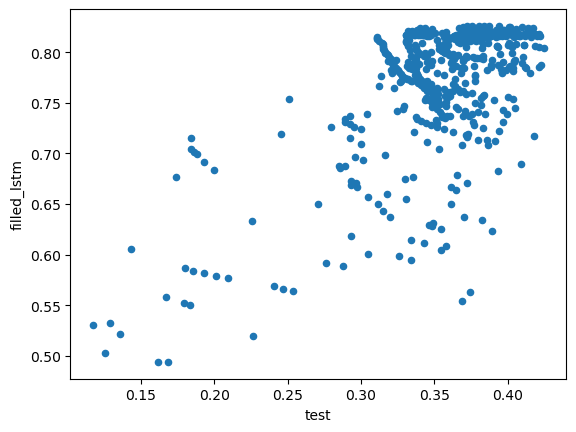

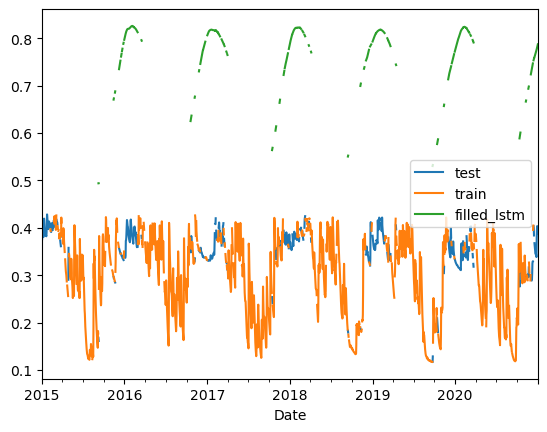

In [36]:
PREDICTION[['test', 'filled_lstm']].plot.scatter(0, 1)
PREDICTION[['test', 'train', 'filled_lstm']].plot()